In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

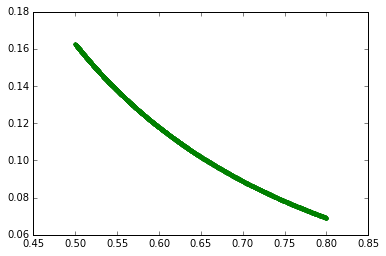

In [3]:
def chabrier(masses = np.linspace(.5, .8, 1000)):
    sigma = .158/masses * np.exp(-(np.log10(masses)-np.log10(.08))**2/(2*.69**2))
    return sigma


testmasses = np.linspace(.5,.8,1000)
test = chabrier(masses = testmasses)
plt.plot(testmasses, test)

randmasses = np.random.choice(testmasses, 10000, p = test/np.sum(test))
randtest = chabrier(masses=randmasses)
plt.plot(randmasses, randtest, '.')
#n, bins, patches = plt.hist(randmasses, bins = 100)

[ 0.04668555 -1.80591995]


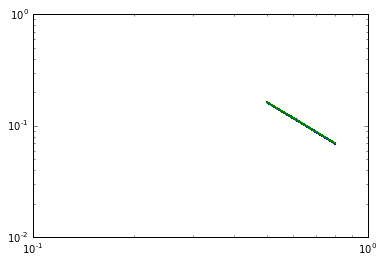

In [11]:
plt.loglog(randmasses,randtest)
#plt.loglog(bins[:-1], n/10000, '.')
error = np.sqrt(randtest)

from scipy import optimize

lstest = optimize.least_squares(lambda x: x[0]*randmasses**x[1] - randtest, [1,1])
print(lstest.x)

plt.loglog(randmasses, lstest.x[0]*randmasses**lstest.x[1])

''' The least squares optimization'''

In [85]:
error = np.sqrt(randtest)
def powerlawmodel(theta, masses):
    model = theta[0]*masses**(-theta[1])
    return model

def logL(theta, x,y, sigma):
    return -.5*np.sum((y-powerlawmodel(theta,x))**2./(error)**2.)

def lnprior(theta):
    if theta[0] < 0:
        return -np.inf
    if theta[1] < 0:
        return -np.inf
    else:
        return 1.

def lnprob(theta, x, y, sigma):
    return lnprior(theta) + logL(theta, x, y, sigma)

import emcee

ndim, nwalkers = 2, 100
pos = [1+1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = [randmasses,randtest, error])
sampler.run_mcmc(pos, 5000);


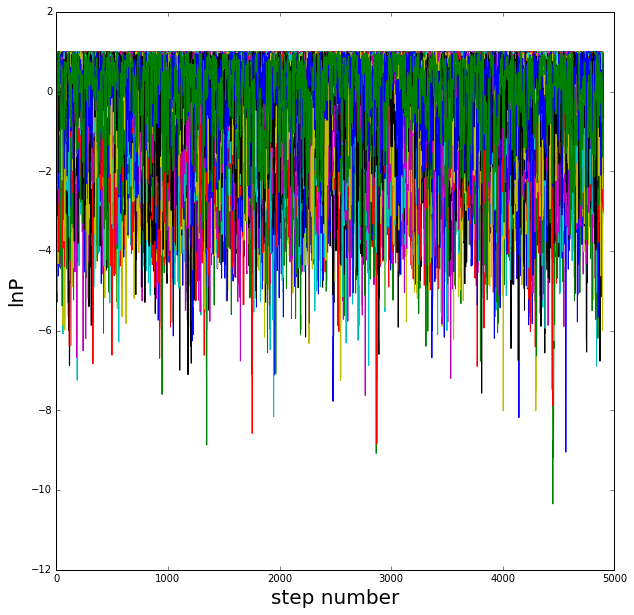

In [73]:
plt.figure(figsize = (10,10))
[plt.plot(sampler.lnprobability[i,100:]) for i in range(100)]
plt.xlabel('step number', fontsize = 20)
plt.ylabel('lnP', fontsize = 20)

constant_mean = 0.0532039910129
constant_std = 0.0173427994363
alpha_mean = 1.60620864263
alpha_std = 0.69503922587


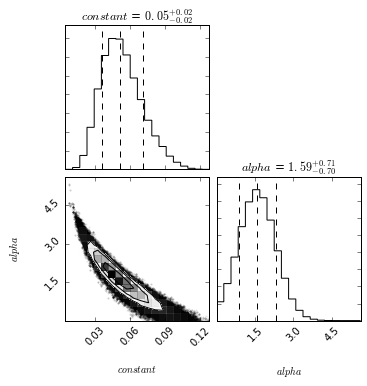

In [77]:
import corner

samples = sampler.chain[:,100:, :].reshape((-1, ndim))
corner.corner(samples, labels=['$constant$', '$alpha$'], fontsize = 30, show_titles = True, quantiles=[0.16, 0.5, 0.84])


print('constant_mean = %s' %(np.mean(samples[:,0])))
print('constant_std = %s' %(np.std(samples[:,0])))
print('alpha_mean = %s' %(np.mean(samples[:,1])))
print('alpha_std = %s' %(np.std(samples[:,1])))

The alpha distribution that we get from this analysis is centered on a value that is close to the Kroupa low-mass alpha value of 1.3. However, the emcee processes also give a surprisingly large standard deviation compared to what might think after just looking at the data. This first method, however, includes a Poisson error. Without that error one would get the histograms below.

constant_mean = 0.0543481609919
constant_std = 0.0192813548959
alpha_mean = 1.61696664152
alpha_std = 0.677436499553


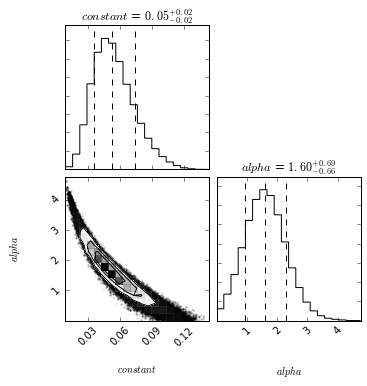

In [13]:
def powerlawmodel(theta, masses):
    model = theta[0]*masses**(-theta[1])
    return model

def logL(theta, x,y):
    return -.5*np.sum((y-powerlawmodel(theta,x))**2.)

def lnprior(theta):
    if theta[0] < 0:
        return -np.inf
    if theta[1] < 0:
        return -np.inf
    else:
        return 1.

def lnprob(theta, x, y):
    return lnprior(theta) + logL(theta, x, y)

import emcee

ndim, nwalkers = 2, 100
pos = [1+1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = [randmasses,randtest])
sampler.run_mcmc(pos, 5000);

import corner

samples = sampler.chain[:,100:, :].reshape((-1, ndim))
corner.corner(samples, labels=['$constant$', '$alpha$'], fontsize = 30, show_titles = True, quantiles=[0.16, 0.5, 0.84])


print('constant_mean = %s' %(np.mean(samples[:,0])))
print('constant_std = %s' %(np.std(samples[:,0])))
print('alpha_mean = %s' %(np.mean(samples[:,1])))
print('alpha_std = %s' %(np.std(samples[:,1])))

Not much changes! The values still don't line up between Chabrier and Kroupa precisely, and the standard deviations have barely closed, even with the new implicit counting error of 1. If we probed even lower masses, we would likely get closer to the Kroupa value of 1.3